# **NYC: Does Crime Ever Sleep in the City That Never Does?**

# Data exploration

source = https://www.kaggle.com/datasets/aniket0712/nypd-complaint-data-historic?resource=download

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from datetime import datetime, date, time

# Data cleaning and preprocessing

In [88]:
data_folder = './data/'
df = pd.read_csv(data_folder+'NYPD_Complaint_Data_Historic.csv', dtype={'CMPLNT_NUM': str})

In [83]:
df.head()

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,...,SUSP_SEX,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX
0,39468181,02/20/2008,07:00:00,02/23/2008,08:00:00,88.0,02/23/2008,107,BURGLARY,221.0,...,(null),NaN,40.692464,-73.972708,"(40.692464, -73.972708)",PATROL BORO BKLYN NORTH,(null),25-44,WHITE,F
1,50539499,08/21/2008,22:00:00,08/21/2008,23:00:00,19.0,08/22/2008,109,GRAND LARCENY,438.0,...,(null),NaN,40.771341,-73.953418,"(40.771341, -73.953418)",PATROL BORO MAN NORTH,(null),45-64,WHITE HISPANIC,F
2,45223390,04/03/2008,03:35:00,04/03/2008,03:50:00,77.0,04/03/2008,106,FELONY ASSAULT,109.0,...,(null),NaN,40.671245,-73.926713,"(40.671245, -73.926713)",PATROL BORO BKLYN NORTH,(null),25-44,BLACK,F
3,50594658,08/19/2008,09:00:00,NaN,(null),32.0,08/27/2008,341,PETIT LARCENY,349.0,...,(null),NaN,40.813412,-73.943226,"(40.813412, -73.943226)",PATROL BORO MAN NORTH,(null),(null),UNKNOWN,M
4,44451016,03/10/2008,22:00:00,03/10/2008,22:10:00,67.0,03/11/2008,105,ROBBERY,397.0,...,M,NaN,40.650142,-73.944674,"(40.650142, -73.944674)",PATROL BORO BKLYN SOUTH,(null),25-44,BLACK,M


In [84]:
print(f"We have {df.shape[0]:,} datapoints with {df.shape[1]} features")

We have 8,914,838 datapoints with 35 features


# NYPD Complaints 

| Column Name      | Description |
|-----------------|-------------|
| **CMPLNT_NUM**  | Unique identifier for each complaint |
| **CMPLNT_FR_DT** | Date when the incident started |
| **CMPLNT_FR_TM** | Time when the incident started |
| **CMPLNT_TO_DT** | Date when the incident ended (if applicable) |
| **CMPLNT_TO_TM** | Time when the incident ended (if applicable) |
| **ADDR_PCT_CD**  | Precinct where the complaint was reported |
| **RPT_DT**       | Date when the complaint was officially recorded |
| **KY_CD**        | Numeric offense code |
| **OFNS_DESC**    | Description of the offense |
| **PD_CD**        | Police department-specific offense code |
| **PD_DESC**      | Description of the police department offense classification |
| **CRM_ATPT_CPTD_CD** | Whether the crime was **completed** or an **attempt** |
| **LAW_CAT_CD**   | Severity of the offense (Felony, Misdemeanor, Violation) |
| **BORO_NM**      | Borough where the crime occurred (Manhattan, Brooklyn, etc.) |
| **LOC_OF_OCCUR_DESC** | Location type (e.g., street, residence, transit) |
| **PREM_TYP_DESC** | Type of premises where the incident occurred (e.g., apartment, store) |
| **JURIS_DESC**   | Jurisdiction responsible for the case |
| **JURISDICTION_CODE** | Numeric jurisdiction code |
| **PARKS_NM**     | Name of the park (if applicable) |
| **HADEVELOPT**   | NYC Housing Authority development name |
| **HOUSING_PSA**  | Housing Police Service Area |
| **X_COORD_CD**   | X-coordinate (NYC coordinate system) |
| **Y_COORD_CD**   | Y-coordinate (NYC coordinate system) |
| **SUSP_AGE_GROUP** | Age group of the suspect |
| **SUSP_RACE**    | Race of the suspect |
| **SUSP_SEX**     | Gender of the suspect |
| **TRANSIT_DISTRICT** | Transit district (if applicable) |
| **Latitude**     | Latitude of the crime location |
| **Longitude**    | Longitude of the crime location |
| **Lat_Lon**      | Combined Latitude & Longitude |
| **PATROL_BORO**  | Patrol Borough where the incident occurred |
| **STATION_NAME** | Subway station name (if applicable) |
| **VIC_AGE_GROUP** | Age group of the victim |
| **VIC_RACE**     | Race of the victim |
| **VIC_SEX**      | Gender of the victim |



### Adding the community district to the dataset for later analysis

The dataset from: https://www.nyc.gov/site/planning/data-maps/open-data/districts-download-metadata.page was used to get the coordinates of the boarders of the community district in order to map the crime locations to the community district it happened in.

In [ ]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import requests

# Convert crime data to GeoDataFrame
df["geometry"] = df.apply(lambda row: Point(row["Longitude"], row["Latitude"]), axis=1)
crime_gdf = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")

# Load NYC district boundaries from GeoJSON
url = "https://services5.arcgis.com/GfwWNkhOj9bNBqoJ/arcgis/rest/services/NYC_Community_Districts/FeatureServer/0/query?where=1=1&outFields=*&outSR=4326&f=pgeojson"
response = requests.get(url)
if response.status_code == 200:
    geo_file = response.json()
    print("GeoJSON file fetched successfully")
else:
    print("Error fetching GeoJSON file")
#districts_gdf = gpd.read_file(geo_file)
community_districts = gpd.GeoDataFrame.from_features(geo_file["features"], crs="EPSG:4326")


# Ensure both datasets have the same CRS (Coordinate Reference System)
districts_gdf = community_districts.to_crs(crime_gdf.crs)

# Perform spatial join (assign crimes to districts)
crime_with_districts = gpd.sjoin(crime_gdf, districts_gdf, how="left", predicate="within")

#df["District"] = crime_with_districts["GEONAME"]
df["District_Code"] = crime_with_districts["BoroCD"] 

print("Mapping complete! geocodes added to crime data.")

GeoJSON file fetched successfully
Mapping complete! geocodes added to crime data.


In [107]:
district_code_map = {
    'Battery Park/Tribeca': 101, 'Greenwich Village': 102, 'Lower East Side': 103,
    'Chelsea/Clinton': 104, 'Midtown Business District': 105, 'Murray Hill/Stuyvesant': 106,
    'Upper West Side': 107, 'Upper East Side': 108, 'Manhattanville': 109, 'Central Harlem': 110,
    'East Harlem': 111, 'Washington Heights': 112, 'Mott Haven': 201, 'Hunts Point': 202,
    'Morrisania': 203, 'Concourse/Highbridge': 204, 'University Heights': 205, 'East Tremont': 206,
    'Bedford Park': 207, 'Riverdale': 208, 'Unionport/Soundview': 209, 'Throgs Neck': 210,
    'Pelham Parkway': 211, 'Williamsbridge': 212, 'Williamsburg/Greenpoint': 301,
    'Fort Greene/Brooklyn Hts': 302, 'Bedford Stuyvesant': 303, 'Bushwick': 304,
    'East New York': 305, 'Park Slope': 306, 'Sunset Park': 307, 'Crown Heights North': 308,
    'Crown Heights South': 309, 'Bay Ridge': 310, 'Bensonhurst': 311, 'Borough Park': 312,
    'Coney Island': 313, 'Flatbush/Midwood': 314, 'Sheepshead Bay': 315, 'Brownsville': 316,
    'East Flatbush': 317, 'Canarsie': 318, 'Astoria': 401, 'Sunnyside/Woodside': 402,
    'Jackson Heights': 403, 'Elmhurst/Corona': 404, 'Ridgewood/Glendale': 405,
    'Rego Park/Forest Hills': 406, 'Flushing': 407, 'Fresh Meadows/Briarwood': 408,
    'Woodhaven': 409, 'Howard Beach': 410, 'Bayside': 411, 'Jamaica/St. Albans': 412,
    'Queens Village': 413, 'The Rockaways': 414, 'St. George': 501, 'South Beach': 502,
    'Tottenville': 503, 'Bronx': 55, 'Brooklyn': 56, 'Manhattan': 64,
    'Queens': 82, 'Staten Island': 95, 'New York City': 99
}

df['District_name'] = df['District_Code'].map({v: k for k, v in district_code_map.items()})

In [ ]:
invalid_values = [355, 356, 164, 226, 227, 228, 480, 481, 482, 483, 484, 595, np.nan]
df = df[~df["District_Code"].isin(invalid_values)]
df.replace("(null)", np.nan, inplace=True)


In [ ]:
date_columns = ["CMPLNT_FR_DT", "CMPLNT_TO_DT", "RPT_DT"]
df[date_columns] = df[date_columns].apply(pd.to_datetime, format='%m/%d/%Y', errors='coerce')

# Calculate case duration (use np.inf if end date is missing = didn t end yet)
df["case_duration"] = df.apply(lambda row: np.inf if pd.isna(row["CMPLNT_TO_DT"]) 
                               else (row["CMPLNT_TO_DT"] - row["CMPLNT_FR_DT"]).days, axis=1)

# U is for unknown so we replace it with nan
df['VIC_SEX'].replace("U", np.nan, inplace=True)
df['VIC_SEX'].replace("L", np.nan, inplace=True)

df["year_begin"] = df['CMPLNT_FR_DT'].dt.year
df['year_begin'] = pd.to_numeric(df['year_begin'], errors='coerce').astype('Int64')

In [138]:
df = df.query("year_begin >= 2006")

In [47]:
df.to_csv(data_folder + 'clean_complaint_data.csv', index=False)

# Loading created data:

In [ ]:
df = pd.read_csv(data_folder + 'clean_complaint_data.csv', dtype={'CMPLNT_NUM': str})

## Analysis of missing values

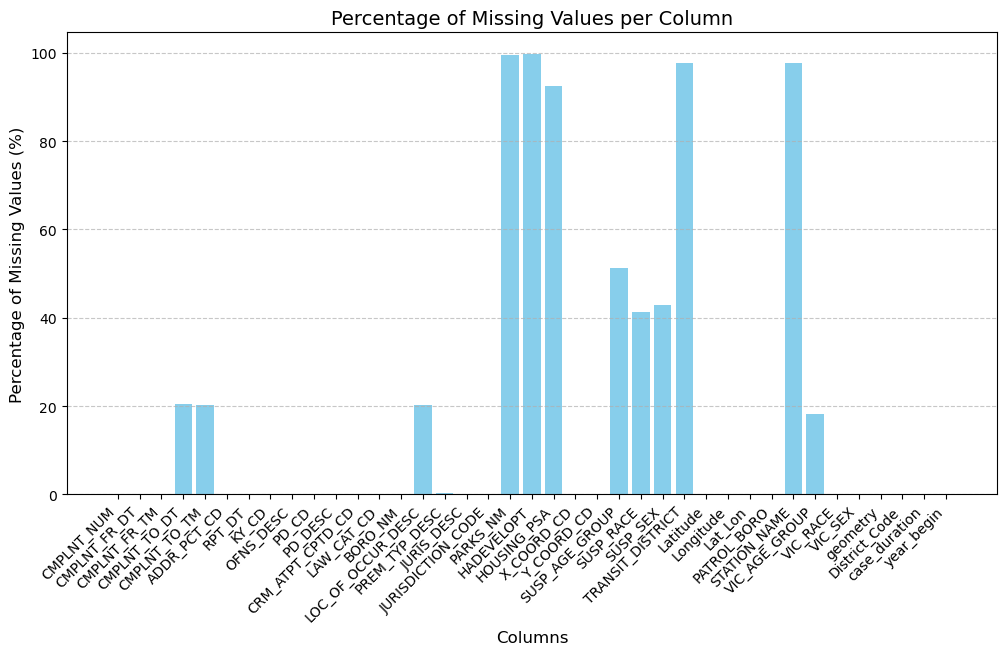

In [ ]:
missing_percentage = (df.isna().sum() / len(df)) * 100

plt.figure(figsize=(12, 6))
plt.bar(missing_percentage.index, missing_percentage.values, color='skyblue')

plt.xticks(rotation=45, ha='right', fontsize=10)
plt.ylabel("Percentage of Missing Values (%)", fontsize=12)
plt.xlabel("Columns", fontsize=12)
plt.title("Percentage of Missing Values per Column", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

Missing values seem to correspond mainly to when the feature is not applicable.

In [96]:
df.isna().sum()

CMPLNT_NUM                 0
CMPLNT_FR_DT             827
CMPLNT_FR_TM              48
CMPLNT_TO_DT         1811942
CMPLNT_TO_TM         1806513
ADDR_PCT_CD              302
RPT_DT                     0
KY_CD                      0
OFNS_DESC              18382
PD_CD                   7488
PD_DESC                 7488
CRM_ATPT_CPTD_CD         168
LAW_CAT_CD                 0
BORO_NM                 7841
LOC_OF_OCCUR_DESC    1801667
PREM_TYP_DESC          38209
JURIS_DESC                 0
JURISDICTION_CODE          0
PARKS_NM             8839013
HADEVELOPT           8840599
HOUSING_PSA          8201869
X_COORD_CD                 0
Y_COORD_CD                 0
SUSP_AGE_GROUP       4558290
SUSP_RACE            3666730
SUSP_SEX             3799179
TRANSIT_DISTRICT     8675796
Latitude                   0
Longitude                  0
Lat_Lon                    0
PATROL_BORO              208
STATION_NAME         8675796
VIC_AGE_GROUP        1614394
VIC_RACE                 665
VIC_SEX       

## Repartition of type of offences

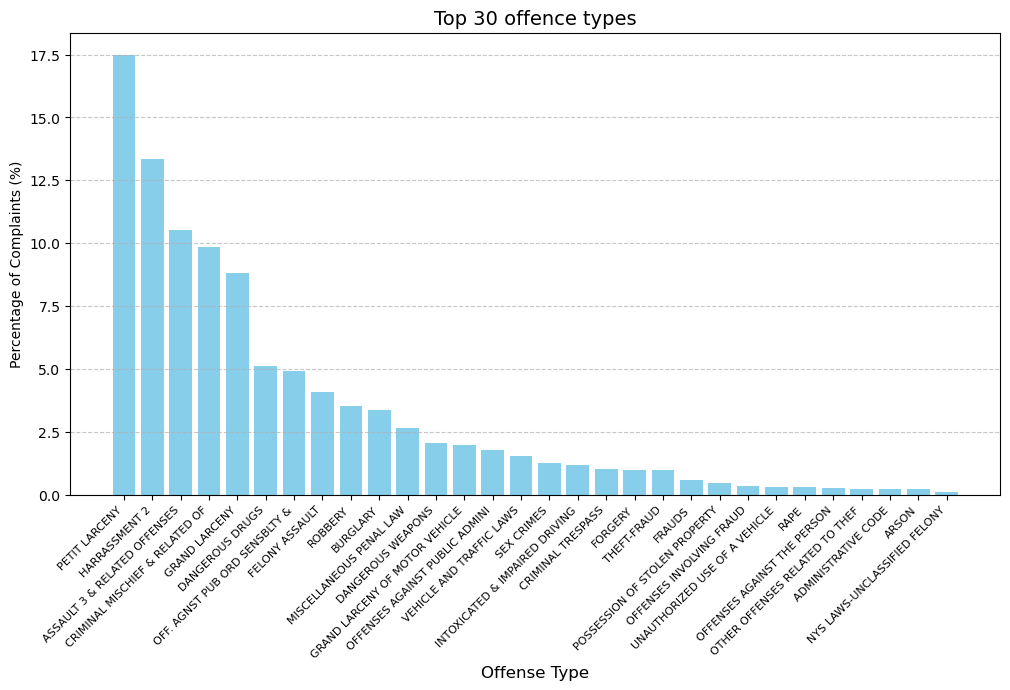

In [97]:
offense_percentage = (df['OFNS_DESC'].value_counts(normalize=True) * 100).head(30)

plt.figure(figsize=(12, 6))
plt.bar(offense_percentage.index, offense_percentage.values, color='skyblue')

plt.xticks(rotation=45, ha='right', fontsize=8)
plt.ylabel("Percentage of Complaints (%)", fontsize=10)
plt.xlabel("Offense Type", fontsize=12)
plt.title("Top 30 offence types", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


# Women centered analysis:

## Percentage of female victims:

In [98]:
df['VIC_SEX'].value_counts()

VIC_SEX
F    3471509
M    2953695
E    1284012
D    1156694
Name: count, dtype: int64

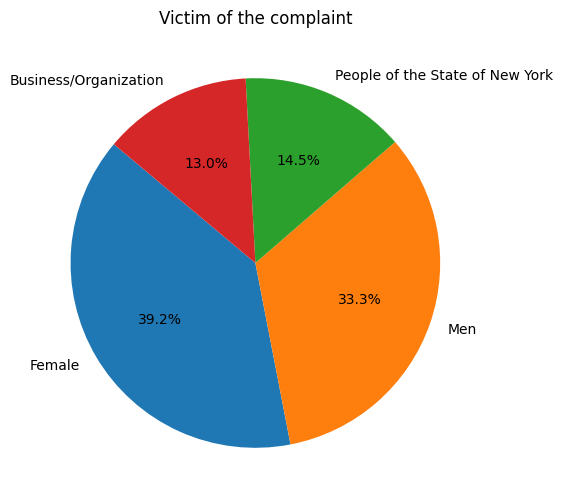

In [103]:
#F=Female
#M=Male
#E=PSNY/People of the State of New York
#D=Business/Organization,


labels= ["Female", "Men", "People of the State of New York", "Business/Organization"]
sizes = df['VIC_SEX'].value_counts()
#sizes["Unknown"] = df["VIC_SEX"].isna().sum()

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Victim of the complaint')
plt.show()

Now taking only when victim is a single person

In [100]:
df_gender = df.query("(VIC_SEX == 'F')| (VIC_SEX =='M')")

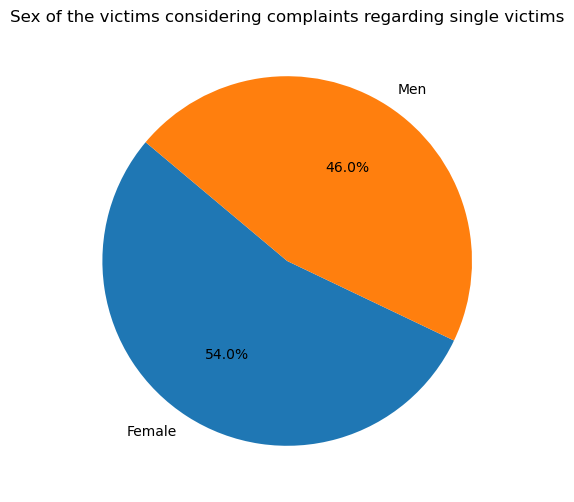

In [101]:
labels= ["Female", "Men"]
sizes = [df_gender['VIC_SEX'].value_counts().get('F', 0),
         df_gender['VIC_SEX'].value_counts().get('M', 0)]


plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Sex of the victims considering complaints regarding single victims')
plt.show()

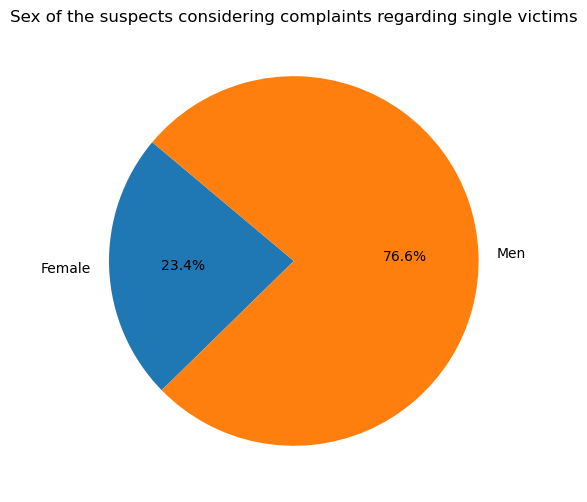

In [102]:
df_gender_susp = df[df['SUSP_SEX'].isin(['F', 'M'])]

labels= ["Female", "Men"]
sizes = [df_gender_susp['SUSP_SEX'].value_counts().get('F', 0),
         df_gender_susp['SUSP_SEX'].value_counts().get('M', 0)]


plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Sex of the suspects considering complaints regarding single victims')
plt.show()

## Types of crimes women and men are victim of:

In [103]:
women_victims = df_gender.query("VIC_SEX == 'F'")
men_victims = df_gender.query("VIC_SEX == 'M'")

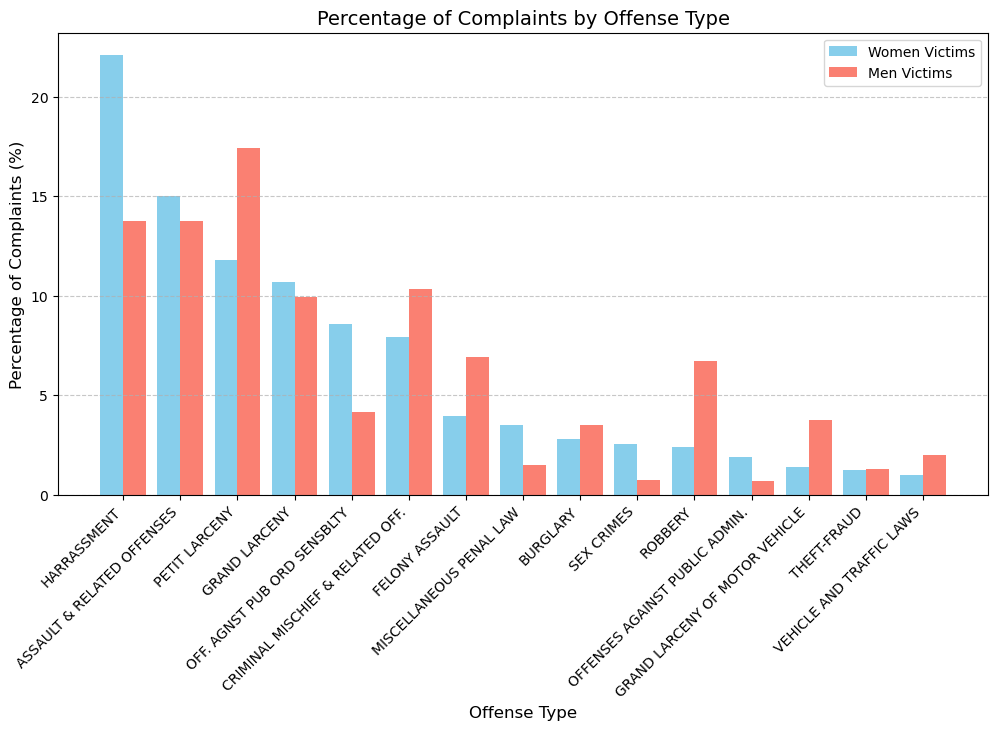

In [ ]:
import matplotlib.pyplot as plt

def rename_dict_key(oldkey, newkey, dict):
    dict[newkey] = dict[oldkey]
    del dict[oldkey]

# Get top 15 offenses for women victims in percentage
top_women_offenses = women_victims['OFNS_DESC'].value_counts(normalize=True)[:15] * 100

# Get offense counts for men victims in percentage
men_offense_counts = men_victims['OFNS_DESC'].value_counts(normalize=True) * 100

# Align men’s offenses with the top 15 women’s offenses
men_percentages = men_offense_counts.reindex(top_women_offenses.index).fillna(0)
rename_dict_key('HARRASSMENT 2','HARRASSMENT',top_women_offenses)
rename_dict_key('ASSAULT 3 & RELATED OFFENSES','ASSAULT & RELATED OFFENSES',top_women_offenses)
rename_dict_key('OFF. AGNST PUB ORD SENSBLTY &', 'OFF. AGNST PUB ORD SENSBLTY',top_women_offenses)
rename_dict_key('CRIMINAL MISCHIEF & RELATED OF', 'CRIMINAL MISCHIEF & RELATED OFF.',top_women_offenses)
rename_dict_key('OFFENSES AGAINST PUBLIC ADMINI', 'OFFENSES AGAINST PUBLIC ADMIN.', top_women_offenses)

rename_dict_key('HARRASSMENT 2','HARRASSMENT',men_percentages)
rename_dict_key('ASSAULT 3 & RELATED OFFENSES','ASSAULT & RELATED OFFENSES',men_percentages)
rename_dict_key('OFF. AGNST PUB ORD SENSBLTY &', 'OFF. AGNST PUB ORD SENSBLTY',men_percentages)
rename_dict_key('CRIMINAL MISCHIEF & RELATED OF', 'CRIMINAL MISCHIEF & RELATED OFF.',men_percentages)
rename_dict_key('OFFENSES AGAINST PUBLIC ADMINI', 'OFFENSES AGAINST PUBLIC ADMIN.', men_percentages)

# Sort top offenses for women victims
top_women_offenses = top_women_offenses.sort_values(ascending=False)
men_percentages = men_percentages.reindex(top_women_offenses.index).fillna(0)

# Plot grouped bar chart
plt.figure(figsize=(12, 6))
bar_width = 0.4
x_labels = top_women_offenses.index
x = range(len(x_labels))

plt.bar(x, top_women_offenses.values, width=bar_width, label="Women Victims", color='skyblue', align='center')
plt.bar([i + bar_width for i in x], men_percentages.values, width=bar_width, label="Men Victims", color='salmon', align='center')

plt.xticks([i + bar_width / 2 for i in x], x_labels, rotation=45, ha="right", fontsize=10)

plt.ylabel("Percentage of Complaints (%)", fontsize=12)
plt.xlabel("Offense Type", fontsize=12)
plt.title("Percentage of Complaints by Offense Type", fontsize=14)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

#plt.savefig('men_vs_women_victims.png', bbox_inches='tight')

plt.show()

## Types of crimes women and men are suspected of:

In [105]:
women_suspect = df_gender.query("SUSP_SEX == 'F'")
men_suspect = df_gender.query("SUSP_SEX == 'M'")

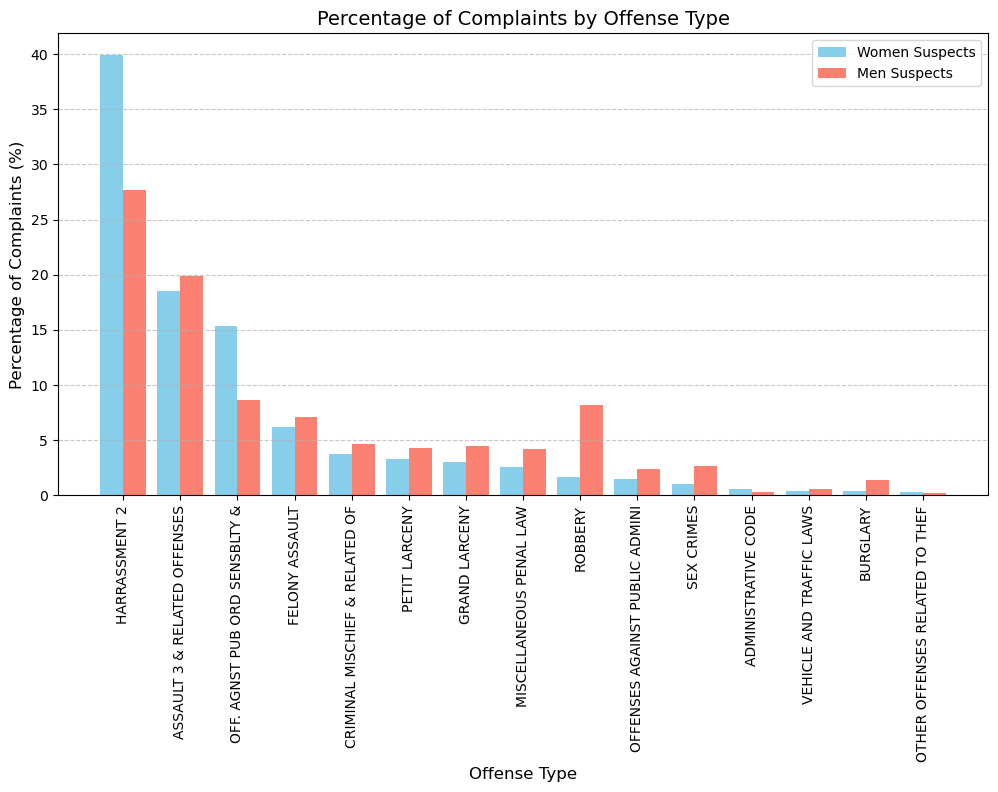

In [106]:
top_women_offenses = women_suspect['OFNS_DESC'].value_counts(normalize=True)[:15] * 100

men_offense_counts = men_suspect['OFNS_DESC'].value_counts(normalize=True) * 100

men_percentages = men_offense_counts.reindex(top_women_offenses.index).fillna(0)

plt.figure(figsize=(12, 6))
bar_width = 0.4
x_labels = top_women_offenses.index
x = range(len(x_labels))

plt.bar(x, top_women_offenses.values, width=bar_width, label="Women Suspects", color='skyblue', align='center')
plt.bar([i + bar_width for i in x], men_percentages.values, width=bar_width, label="Men Suspects", color='salmon', align='center')

plt.xticks([i + bar_width / 2 for i in x], x_labels, rotation=90, fontsize=10)
plt.ylabel("Percentage of Complaints (%)", fontsize=12)
plt.xlabel("Offense Type", fontsize=12)
plt.title("Percentage of Complaints by Offense Type", fontsize=14)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

## Dangerous hours for men VS women:

{'07': 90182, '22': 156837, '03': 68493, '15': 208377, '19': 188351, '20': 188285, '23': 142702, '21': 170283, '06': 54648, '01': 102324, '11': 152120, '18': 201130, '00': 158343, '14': 184800, '08': 145165, '12': 211073, '05': 48236, '17': 195492, '02': 82462, '13': 167250, '16': 192362, '10': 153199, '09': 151343, '04': 58031}


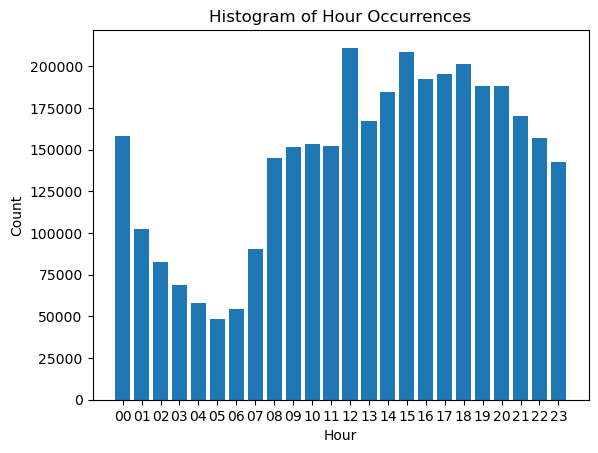

In [107]:
hours=women_victims['CMPLNT_FR_TM'].str[:2]
hours=hours[~(hours=='(n')]
hours_dict=hours.value_counts(sort=False).to_dict()
print(hours_dict)
hours_sorted = dict(sorted(hours_dict.items(), key=lambda x: int(x[0])))

plt.bar(hours_sorted.keys(), hours_sorted.values())
plt.xlabel("Hour")
plt.ylabel("Count")
plt.title("Histogram of Hour Occurrences")
plt.show()

{'22': 116134, '19': 128830, '23': 107654, '01': 84562, '11': 102164, '00': 107397, '14': 124970, '12': 125382, '17': 131351, '06': 41999, '21': 124634, '05': 43801, '20': 131482, '18': 133241, '15': 140757, '13': 112082, '16': 132074, '07': 58004, '10': 97627, '08': 84302, '04': 58168, '03': 63862, '02': 72512, '09': 89013}


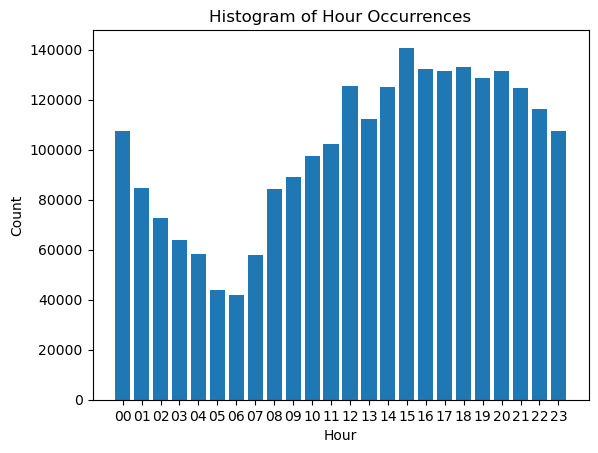

In [108]:
hours=men_suspect['CMPLNT_FR_TM'].str[:2]
hours=hours[~(hours=='(n')]
hours_dict=hours.value_counts(sort=False).to_dict()
print(hours_dict)
hours_sorted = dict(sorted(hours_dict.items(), key=lambda x: int(x[0])))

plt.bar(hours_sorted.keys(), hours_sorted.values())
plt.xlabel("Hour")
plt.ylabel("Count")
plt.title("Histogram of Hour Occurrences")
plt.show()

# How did crime evolve through the years

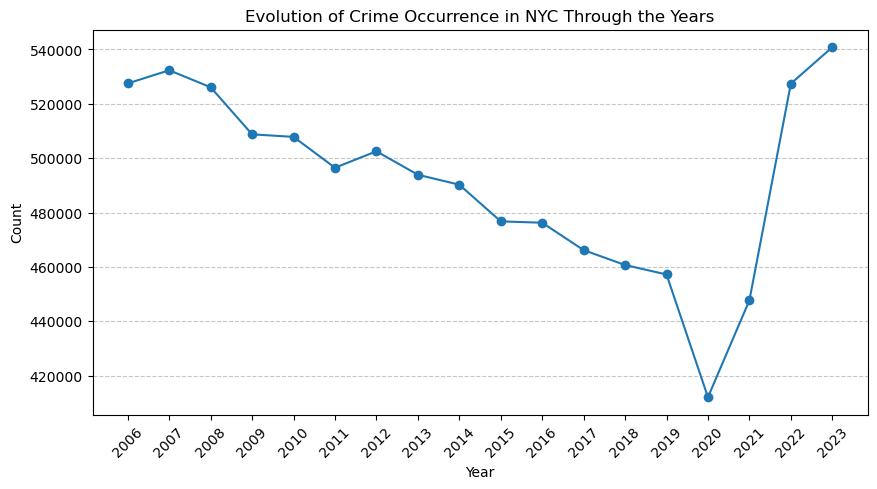

In [109]:
import matplotlib.pyplot as plt

df_year = df.groupby('year_begin').agg(
    nb_crimes=('year_begin', 'size')
).reset_index()

#Crop from 2006 not enough data
df_year = df_year.query("year_begin >= 2006")

plt.figure(figsize=(10, 5))

# Line plot with dots at each year
plt.plot(df_year["year_begin"], df_year["nb_crimes"], marker='o', linestyle='-')

# X-axis labels: show every year, rotate for readability
plt.xticks(df_year["year_begin"], rotation=45)

plt.xlabel("Year")
plt.ylabel("Count")
plt.title("Evolution of Crime Occurrence in NYC Through the Years")

plt.grid(axis="y", linestyle="--", alpha=0.7)  # Optional grid for readability
plt.show()



Interesting result. A drop in 2020 during covid, then a huge increase.

## Main offences targetting "People of the State of New York" and "organization"

In [110]:
#F=Female
#M=Male
#E=PSNY/People of the State of New York
#D=Business/Organization,
#L

df_E = df.query("VIC_SEX == 'E'")
print(df_E["OFNS_DESC"].value_counts().head(10))

OFNS_DESC
DANGEROUS DRUGS                   448109
DANGEROUS WEAPONS                 160845
CRIMINAL MISCHIEF & RELATED OF    119423
INTOXICATED & IMPAIRED DRIVING     96631
OFFENSES AGAINST PUBLIC ADMINI     68297
FORGERY                            67422
MISCELLANEOUS PENAL LAW            56492
CRIMINAL TRESPASS                  49180
VEHICLE AND TRAFFIC LAWS           40586
OFFENSES INVOLVING FRAUD           19496
Name: count, dtype: int64


In [111]:
df_D = df.query("VIC_SEX == 'D'")
print(df_D["OFNS_DESC"].value_counts().head(10))

OFNS_DESC
PETIT LARCENY                     614615
CRIMINAL MISCHIEF & RELATED OF    173438
GRAND LARCENY                     111721
BURGLARY                           95899
ROBBERY                            30765
GRAND LARCENY OF MOTOR VEHICLE     14751
CRIMINAL TRESPASS                  14360
POSSESSION OF STOLEN PROPERTY      12850
OFFENSES INVOLVING FRAUD           11376
FORGERY                            11174
Name: count, dtype: int64


# Complaints by borough

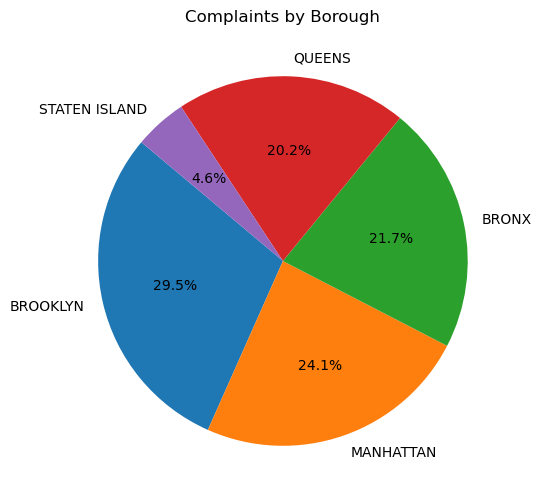

In [112]:
sizes = df['BORO_NM'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=sizes.keys(), autopct='%1.1f%%', startangle=140)
plt.title('Complaints by Borough')
plt.show()

In [114]:
nbr_crimes_by_district = df.groupby('District_Code').size().reset_index(name='nbr_crimes')
nbr_crimes_by_district['District_name'] = nbr_crimes_by_district['District_Code'].map({v: k for k, v in district_code_map.items()})
nbr_crimes_by_district.head()

,District_Code,nbr_crimes,District_name
0,101.0,105471,Battery Park/Tribeca
1,102.0,169289,Greenwich Village
2,103.0,214337,Lower East Side
3,104.0,159072,Chelsea/Clinton
4,105.0,322676,Midtown Business District


# Economic situation NYC

The required dataset was obtain from: https://data.cccnewyork.org/data/download#0,8/66

In [113]:
folder_eco = data_folder + 'data_eco/'
df_poverty = pd.read_csv(folder_eco+'Poverty.csv', sep=',', skiprows=4)
df_poverty = df_poverty.rename(columns={'Data': 'individuals_below_FPL'})
df_poverty = df_poverty.rename(columns={'TimeFrame': 'Year'})
df_poverty = df_poverty.rename(columns={'Location': 'District'})
df_poverty = df_poverty.query("DataFormat  == 'Percent'").reset_index()
df_poverty.drop(["index","Fips","DataFormat"], axis=1, inplace =True)

In [114]:
df2 = pd.read_csv(folder_eco+'Employment_Population_Ratio.csv', sep=',', skiprows=4)
df2 = df2.query("DataFormat == 'Percent'").reset_index()
df2 = df2.rename(columns={'Data': 'Employement_pop_ratio'})
df2 = df2.rename(columns={'TimeFrame': 'Year'})
df2 = df2.rename(columns={'Location': 'District'})
df2.drop(["index","Fips","DataFormat"], axis=1, inplace =True)

In [115]:
df2.head()

,District,Year,Employement_pop_ratio
0,Battery Park/Tribeca,2005,0.751
1,Greenwich Village,2005,0.751
2,Lower East Side,2005,0.564
3,Chelsea/Clinton,2005,0.677
4,Midtown Business District,2005,0.677


In [116]:
df_eco = pd.merge(df_poverty, 
                  df2, 
                  on=["District", "Year"],
                  how='outer')

district_code_map = {
    'Battery Park/Tribeca': 101, 'Greenwich Village': 102, 'Lower East Side': 103,
    'Chelsea/Clinton': 104, 'Midtown Business District': 105, 'Murray Hill/Stuyvesant': 106,
    'Upper West Side': 107, 'Upper East Side': 108, 'Manhattanville': 109, 'Central Harlem': 110,
    'East Harlem': 111, 'Washington Heights': 112, 'Mott Haven': 201, 'Hunts Point': 202,
    'Morrisania': 203, 'Concourse/Highbridge': 204, 'University Heights': 205, 'East Tremont': 206,
    'Bedford Park': 207, 'Riverdale': 208, 'Unionport/Soundview': 209, 'Throgs Neck': 210,
    'Pelham Parkway': 211, 'Williamsbridge': 212, 'Williamsburg/Greenpoint': 301,
    'Fort Greene/Brooklyn Hts': 302, 'Bedford Stuyvesant': 303, 'Bushwick': 304,
    'East New York': 305, 'Park Slope': 306, 'Sunset Park': 307, 'Crown Heights North': 308,
    'Crown Heights South': 309, 'Bay Ridge': 310, 'Bensonhurst': 311, 'Borough Park': 312,
    'Coney Island': 313, 'Flatbush/Midwood': 314, 'Sheepshead Bay': 315, 'Brownsville': 316,
    'East Flatbush': 317, 'Canarsie': 318, 'Astoria': 401, 'Sunnyside/Woodside': 402,
    'Jackson Heights': 403, 'Elmhurst/Corona': 404, 'Ridgewood/Glendale': 405,
    'Rego Park/Forest Hills': 406, 'Flushing': 407, 'Fresh Meadows/Briarwood': 408,
    'Woodhaven': 409, 'Howard Beach': 410, 'Bayside': 411, 'Jamaica/St. Albans': 412,
    'Queens Village': 413, 'The Rockaways': 414, 'St. George': 501, 'South Beach': 502,
    'Tottenville': 503, 'Bronx': 55, 'Brooklyn': 56, 'Manhattan': 64,
    'Queens': 82, 'Staten Island': 95, 'New York City': 99
}
df_eco['District_Code'] = df_eco['District'].map(district_code_map)
invalid_values = [99, 95, 82, 64, 56, 55]
df_eco = df_eco[~df_eco["District_Code"].isin(invalid_values)]


In [117]:
df_eco.head()
df_eco.to_csv(data_folder + "eco_data.csv", index=False)

In [118]:
df_eco = pd.read_csv(data_folder+'eco_data.csv')
df_eco.head()   

,District,Year,individuals_below_FPL,Employement_pop_ratio,District_Code
0,Astoria,2005,0.18347,0.593,401
1,Astoria,2006,0.17182,0.592,401
2,Astoria,2007,0.16717,0.603,401
3,Astoria,2008,0.16424,0.638,401
4,Astoria,2009,0.15914,0.608,401


# Data Analysis of social economic conditions

In [119]:
df_eco_by_district = df_eco.groupby('District_Code').agg(
                    District = ('District', 'first'),
                    individuals_below_FPL_mean = ('individuals_below_FPL', 'mean'),
                    individuals_below_FPL_std = ('individuals_below_FPL', 'std'),
                    Employement_pop_ratio_mean = ('Employement_pop_ratio', 'mean'),
                    Employement_pop_ratio_std = ('Employement_pop_ratio', 'std'),
).reset_index()

df_eco_by_district.head()


,District_Code,District,individuals_below_FPL_mean,individuals_below_FPL_std,Employement_pop_ratio_mean,Employement_pop_ratio_std
0,101,Battery Park/Tribeca,0.082432,0.013163,0.695889,0.106929
1,102,Greenwich Village,0.082432,0.013163,0.703876,0.074474
2,103,Lower East Side,0.263308,0.024709,0.541882,0.016074
3,104,Chelsea/Clinton,0.130939,0.013761,0.690845,0.070434
4,105,Midtown Business District,0.127174,0.015678,0.677218,0.123798


In [120]:
def plot_top_bottom_n(df, value_col, error_col, label_y, n=10, best=True):
    """
    Plots a bar chart with error bars for the top or bottom n values of a given column.
    
    Parameters:
    df (pd.DataFrame): The dataframe containing the data.
    value_col (str): The column name to plot (mean values).
    error_col (str): The column name for error bars (standard deviation values).
    n (int): The number of best or worst values to display.
    best (bool): If True, plot the top n values; if False, plot the bottom n values.
    """
    df_sorted = df.sort_values(by=value_col, ascending=not best).head(n)
    
    color = "red" if best else "green"
    plt.figure(figsize=(10, 6))
    plt.bar(df_sorted['District'], df_sorted[value_col], yerr=df_sorted[error_col], capsize=5, alpha=0.7, color=color)
    
    plt.xlabel('District')
    plt.ylabel(label_y)
    plt.title(f"{'Top' if best else 'Bottom'} {n} Districts by {label_y}")
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    
    plt.show()

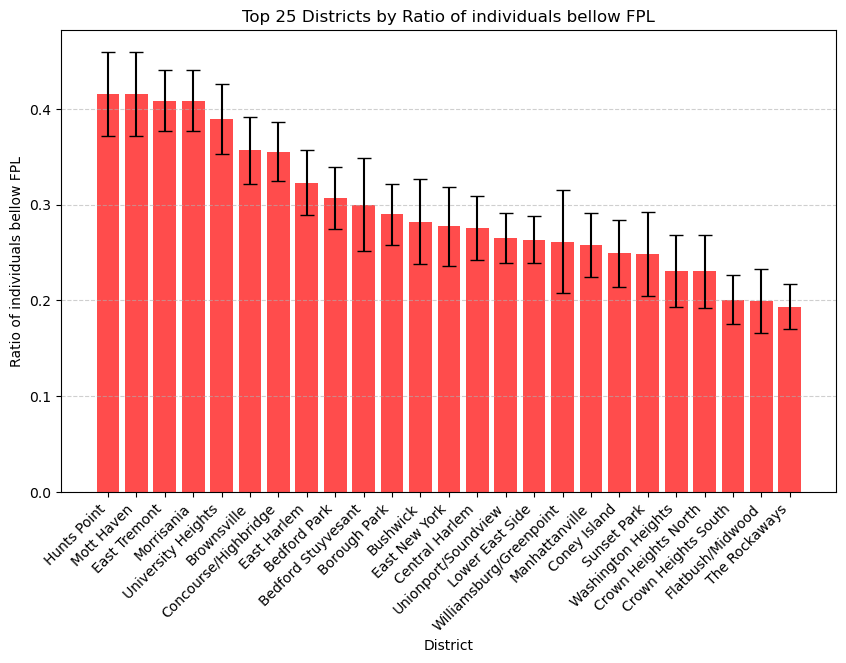

In [121]:
label_y = "Ratio of individuals bellow FPL"
plot_top_bottom_n(df_eco_by_district, "individuals_below_FPL_mean", "individuals_below_FPL_std", label_y, n=25, best=True)

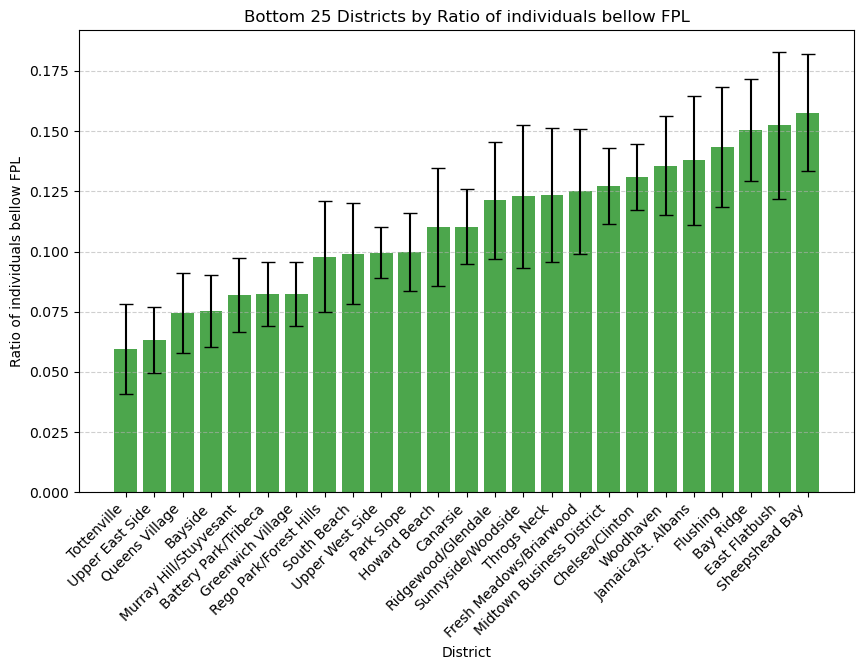

In [122]:
plot_top_bottom_n(df_eco_by_district, "individuals_below_FPL_mean", "individuals_below_FPL_std", label_y, n=25, best=False)

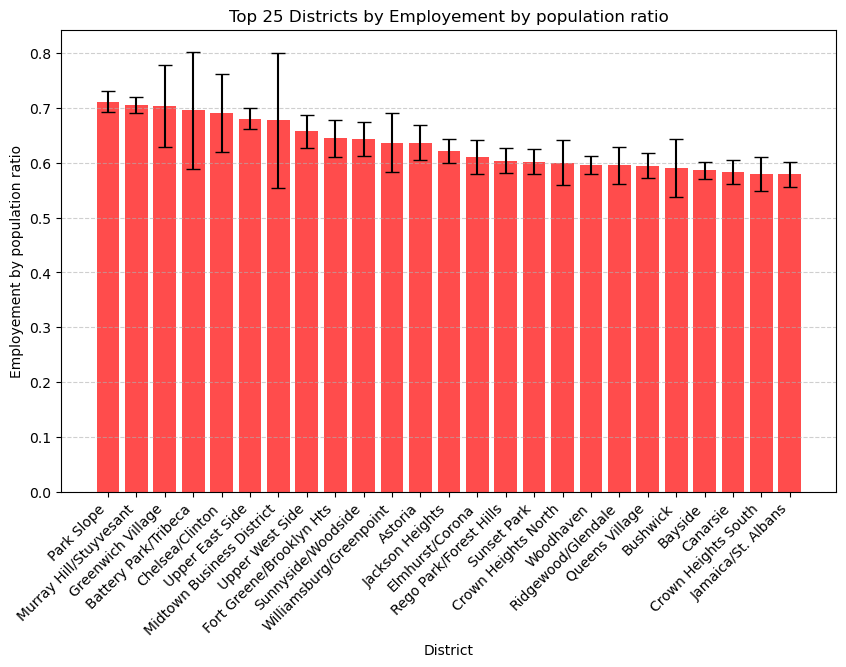

In [123]:
label_y = "Employement by population ratio"
plot_top_bottom_n(df_eco_by_district, "Employement_pop_ratio_mean", "Employement_pop_ratio_std", label_y, n=25, best=True)

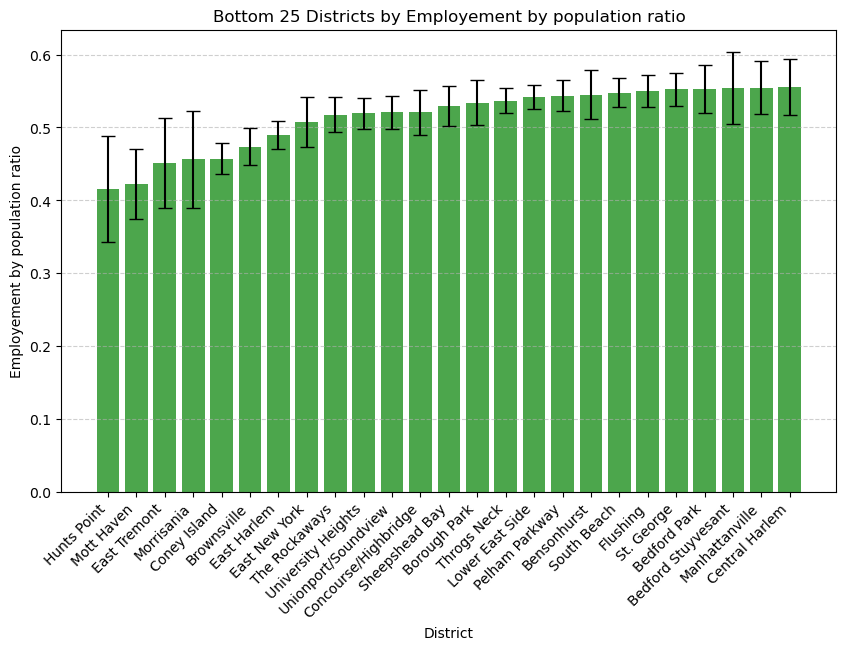

In [124]:
plot_top_bottom_n(df_eco_by_district, "Employement_pop_ratio_mean", "Employement_pop_ratio_std", label_y, n=25, best=False)

## Crime and social economic analysis

In [139]:
nbr_crimes_by_district_year = df.groupby(['District_Code', 'year_begin', 'District_name']).size().reset_index(name='nbr_crimes')

# Compute mean and standard deviation of crimes per year for each district
district_crime_stats = nbr_crimes_by_district_year.groupby('District_Code').agg(
    mean_crimes_by_year=('nbr_crimes', 'mean'),
    std_crimes=('nbr_crimes', 'std'),
    District=('District_name', 'first')
).reset_index()

district_crime_stats.head()

,District_Code,mean_crimes_by_year,std_crimes,District
0,101.0,5845.777778,790.584561,Battery Park/Tribeca
1,102.0,9389.166667,1011.231006,Greenwich Village
2,103.0,11882.500000,1075.282904,Lower East Side
3,104.0,8815.666667,600.566497,Chelsea/Clinton
4,105.0,17896.666667,2320.817376,Midtown Business District


In [140]:
df_eco_by_district_mean = df_eco_by_district.groupby('District_Code').agg(
    individuals_below_FPL_mean = ('individuals_below_FPL_mean', 'mean'),
    Employement_pop_ratio_mean = ('Employement_pop_ratio_mean', 'mean')
).reset_index()

crimes_eco = pd.merge(district_crime_stats,
                      df_eco_by_district_mean,
                      on='District_Code',
                      how='inner')

crimes_eco.head()

,District_Code,mean_crimes_by_year,std_crimes,District,individuals_below_FPL_mean,Employement_pop_ratio_mean
0,101.0,5845.777778,790.584561,Battery Park/Tribeca,0.082432,0.695889
1,102.0,9389.166667,1011.231006,Greenwich Village,0.082432,0.703876
2,103.0,11882.500000,1075.282904,Lower East Side,0.263308,0.541882
3,104.0,8815.666667,600.566497,Chelsea/Clinton,0.130939,0.690845
4,105.0,17896.666667,2320.817376,Midtown Business District,0.127174,0.677218


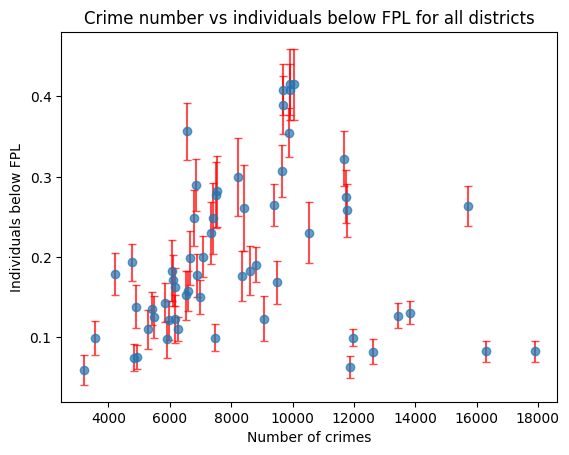

In [ ]:

sorted_crimes = crimes_eco.sort_values(by='mean_crimes_by_year', ascending=False)

df_eco_by_district_test = df_eco_by_district['District_Code'].isin(sorted_crimes['District_Code'])
df_eco_by_district_test = df_eco_by_district[df_eco_by_district_test]

y_errors = df_eco_by_district_test['individuals_below_FPL_std']

fig, ax = plt.subplots()

# Scatter plot with error bars on the y-axis
ax.errorbar(
    sorted_crimes['mean_crimes_by_year'],
    df_eco_by_district_test['individuals_below_FPL_mean'],
    yerr=y_errors, 
    fmt='o', 
    ecolor='red', 
    alpha=0.7, 
    capsize=3 
)

ax.set_xlabel('Number of crimes by year')
ax.set_ylabel('Individuals below FPL')
ax.set_title('Crime number vs individuals below FPL for all districts')

plt.show()

Pearson correlation has a coefficient of 0.355 which is higly significant with a p-value of 0.00578.


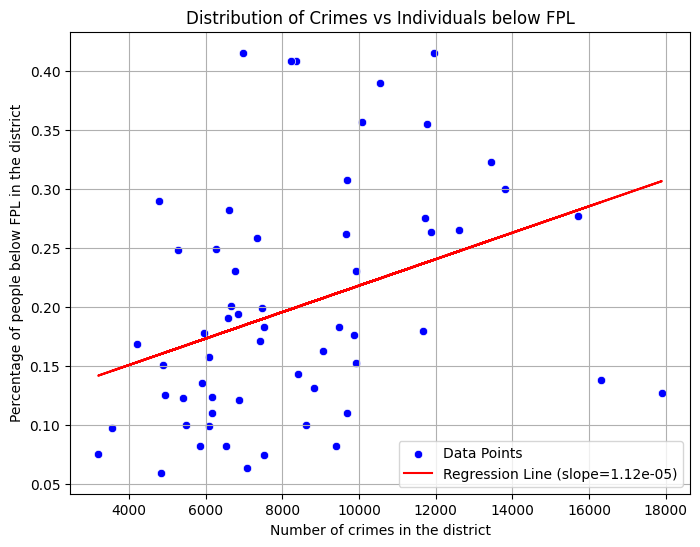

In [ ]:
from scipy import stats
from scipy.stats import linregress
x = crimes_eco['mean_crimes_by_year']
y = crimes_eco['individuals_below_FPL_mean']

slope, intercept, r_value, p_value, std_err = linregress(x, y)
regression_line = slope * x + intercept

pearson = stats.pearsonr(x, y)
print(f"Pearson correlation has a coefficient of {pearson[0]:.3} which is higly significant with a p-value of {pearson[1]:.3}.")

# Plot the scatter plot and regression line
plt.figure(figsize=(8, 6))
sns.scatterplot(x=x, y=y, color='blue', label='Data Points')
plt.plot(x, regression_line, color='red', label=f'Regression Line (slope={slope:.3})')
plt.title(f'Distribution of Crimes vs Individuals below FPL')
plt.xlabel('Number of crimes in the district')
plt.ylabel('Percentage of people below FPL in the district')
plt.legend()
plt.grid(True)
plt.show()

In [143]:
spearman = stats.spearmanr(crimes_eco['mean_crimes_by_year'],crimes_eco['individuals_below_FPL_mean'])
print(f"Spearman correlation has a coefficient of {spearman[0]:.3} with a p-value of {spearman[1]:.3}.")

Spearman correlation has a coefficient of 0.453 with a p-value of 0.000318.


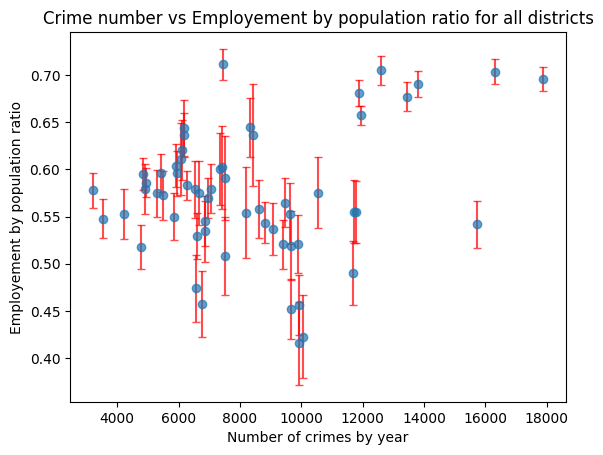

In [ ]:
sorted_crimes = crimes_eco.sort_values(by='mean_crimes_by_year', ascending=False)

df_eco_by_district_test = df_eco_by_district['District_Code'].isin(sorted_crimes['District_Code'])
df_eco_by_district_test = df_eco_by_district[df_eco_by_district_test]

fig, ax = plt.subplots()

ax.errorbar(
    sorted_crimes['mean_crimes_by_year'],
    df_eco_by_district_test['Employement_pop_ratio_mean'],
    yerr=y_errors,  
    fmt='o', 
    ecolor='red',  
    alpha=0.7, 
    capsize=3  
)

ax.set_xlabel('Number of crimes by year')
ax.set_ylabel('Employement by population ratio')
ax.set_title('Crime number vs Employement by population ratio for all districts')

plt.show()

Pearson correlation has a coefficient of -0.142 which is higly significant with a p-value of 0.284.


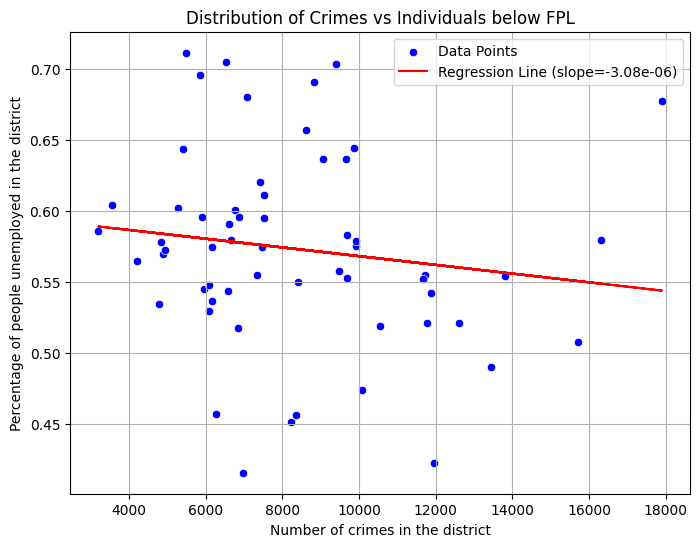

In [ ]:
from scipy.stats import linregress
x = crimes_eco['mean_crimes_by_year']
y = crimes_eco['Employement_pop_ratio_mean']

slope, intercept, r_value, p_value, std_err = linregress(x, y)
regression_line = slope * x + intercept

pearson = stats.pearsonr(x, y)
print(f"Pearson correlation has a coefficient of {pearson[0]:.3} which is higly significant with a p-value of {pearson[1]:.3}.")

plt.figure(figsize=(8, 6))
sns.scatterplot(x=x, y=y, color='blue', label='Data Points')
plt.plot(x, regression_line, color='red', label=f'Regression Line (slope={slope:.3})')
plt.title(f'Distribution of Crimes vs Individuals below FPL')
plt.xlabel('Number of crimes in the district')
plt.ylabel('Percentage of people unemployed in the district')
plt.legend()
plt.grid(True)
plt.show()

In [147]:
spearman = stats.spearmanr(crimes_eco['mean_crimes_by_year'],crimes_eco['Employement_pop_ratio_mean'])
print(f"Spearman correlation has a coefficient of {spearman[0]:.3} with a p-value of {spearman[1]:.3}.")

Spearman correlation has a coefficient of -0.211 with a p-value of 0.108.


### Extra potential data pathways to explore 

In [152]:
df_eco_by_district_test.head()
sorted_crimes.head()
df.sample(5)

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,...,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,geometry,District_Code,case_duration,year_begin
6788760,246919880,2022-06-21,03:55:00,2022-06-21,04:00:00,94.0,2022-06-21,344,ASSAULT 3 & RELATED OFFENSES,101.0,...,"(40.71783501, -73.95772467)",PATROL BORO BKLYN NORTH,BEDFORD AVENUE,25-44,BLACK,F,POINT (-73.95772467 40.71783501),301.0,0.0,2022.0
7938032,23669818,2006-08-01,16:20:00,2006-08-01,16:25:00,52.0,2006-08-01,235,DANGEROUS DRUGS,567.0,...,"(40.865255, -73.896415)",PATROL BORO BRONX,NaN,NaN,UNKNOWN,E,POINT (-73.896415 40.865255),207.0,0.0,2006.0
5560192,195248644,2019-03-26,23:00:00,2019-03-27,00:00:00,73.0,2019-03-27,344,ASSAULT 3 & RELATED OFFENSES,101.0,...,"(40.683454, -73.915939)",PATROL BORO BKLYN NORTH,NaN,<18,BLACK,F,POINT (-73.915939 40.683454),316.0,1.0,2019.0
6287930,224991612,2021-02-22,19:00:00,2021-02-27,19:00:00,71.0,2021-02-28,361,OFF. AGNST PUB ORD SENSBLTY &,639.0,...,"(40.667748, -73.929828)",PATROL BORO BKLYN SOUTH,NaN,45-64,WHITE,F,POINT (-73.929828 40.667748),309.0,5.0,2021.0
1761358,77552634,2011-03-02,20:15:00,2011-03-02,20:20:00,83.0,2011-03-02,126,MISCELLANEOUS PENAL LAW,198.0,...,"(40.692763, -73.907724)",PATROL BORO BKLYN NORTH,NaN,25-44,WHITE HISPANIC,F,POINT (-73.907724 40.692763),304.0,0.0,2011.0


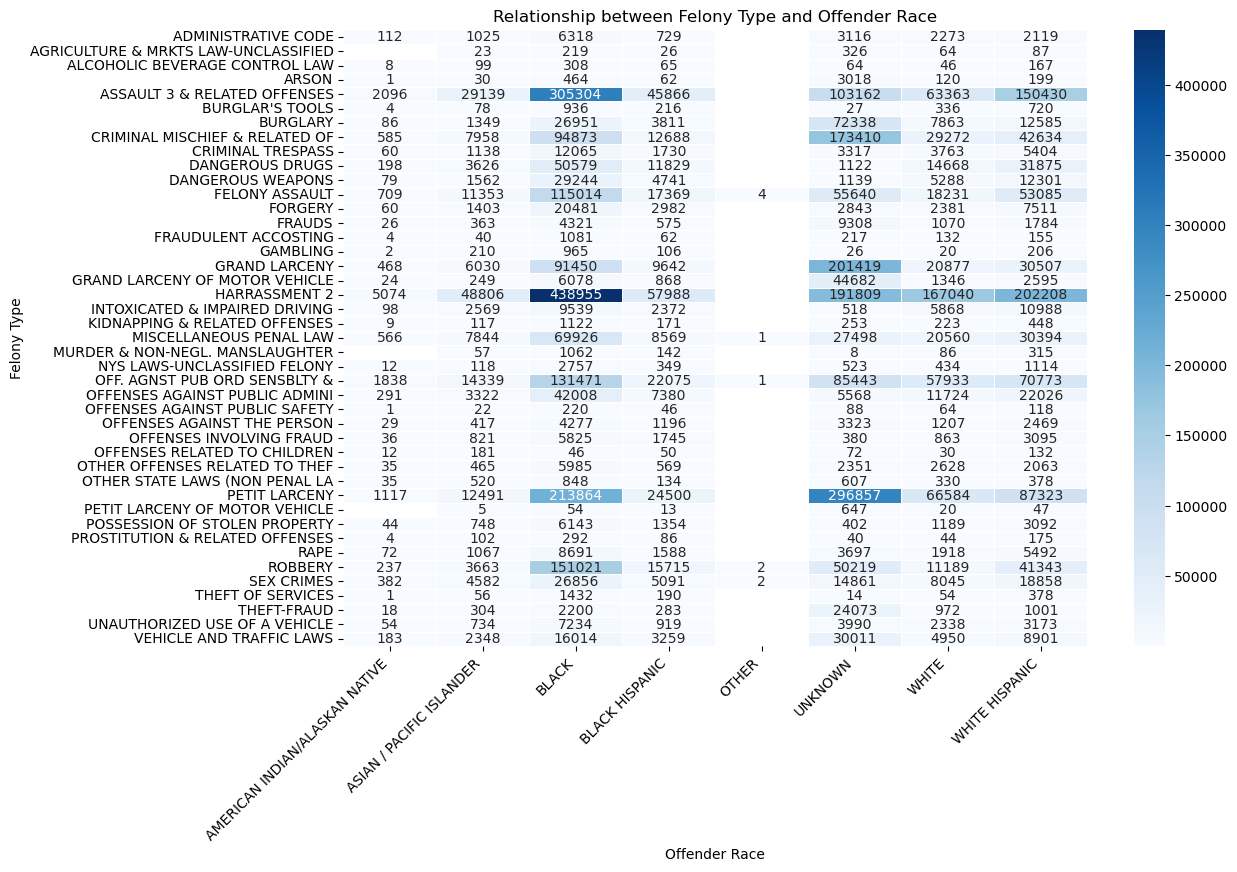

In [163]:
crime_race_counts = df.groupby(['OFNS_DESC', 'SUSP_RACE']).size().unstack()

filtered_crime_counts = crime_race_counts[crime_race_counts.sum(axis=1) > 500]


plt.figure(figsize=(12, 8))
sns.heatmap(filtered_crime_counts, cmap='Blues', annot=True, fmt='g', linewidths=0.5)
plt.title('Relationship between Felony Type and Offender Race')
plt.xlabel('Offender Race')
plt.ylabel('Felony Type')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()


<Figure size 1400x600 with 0 Axes>

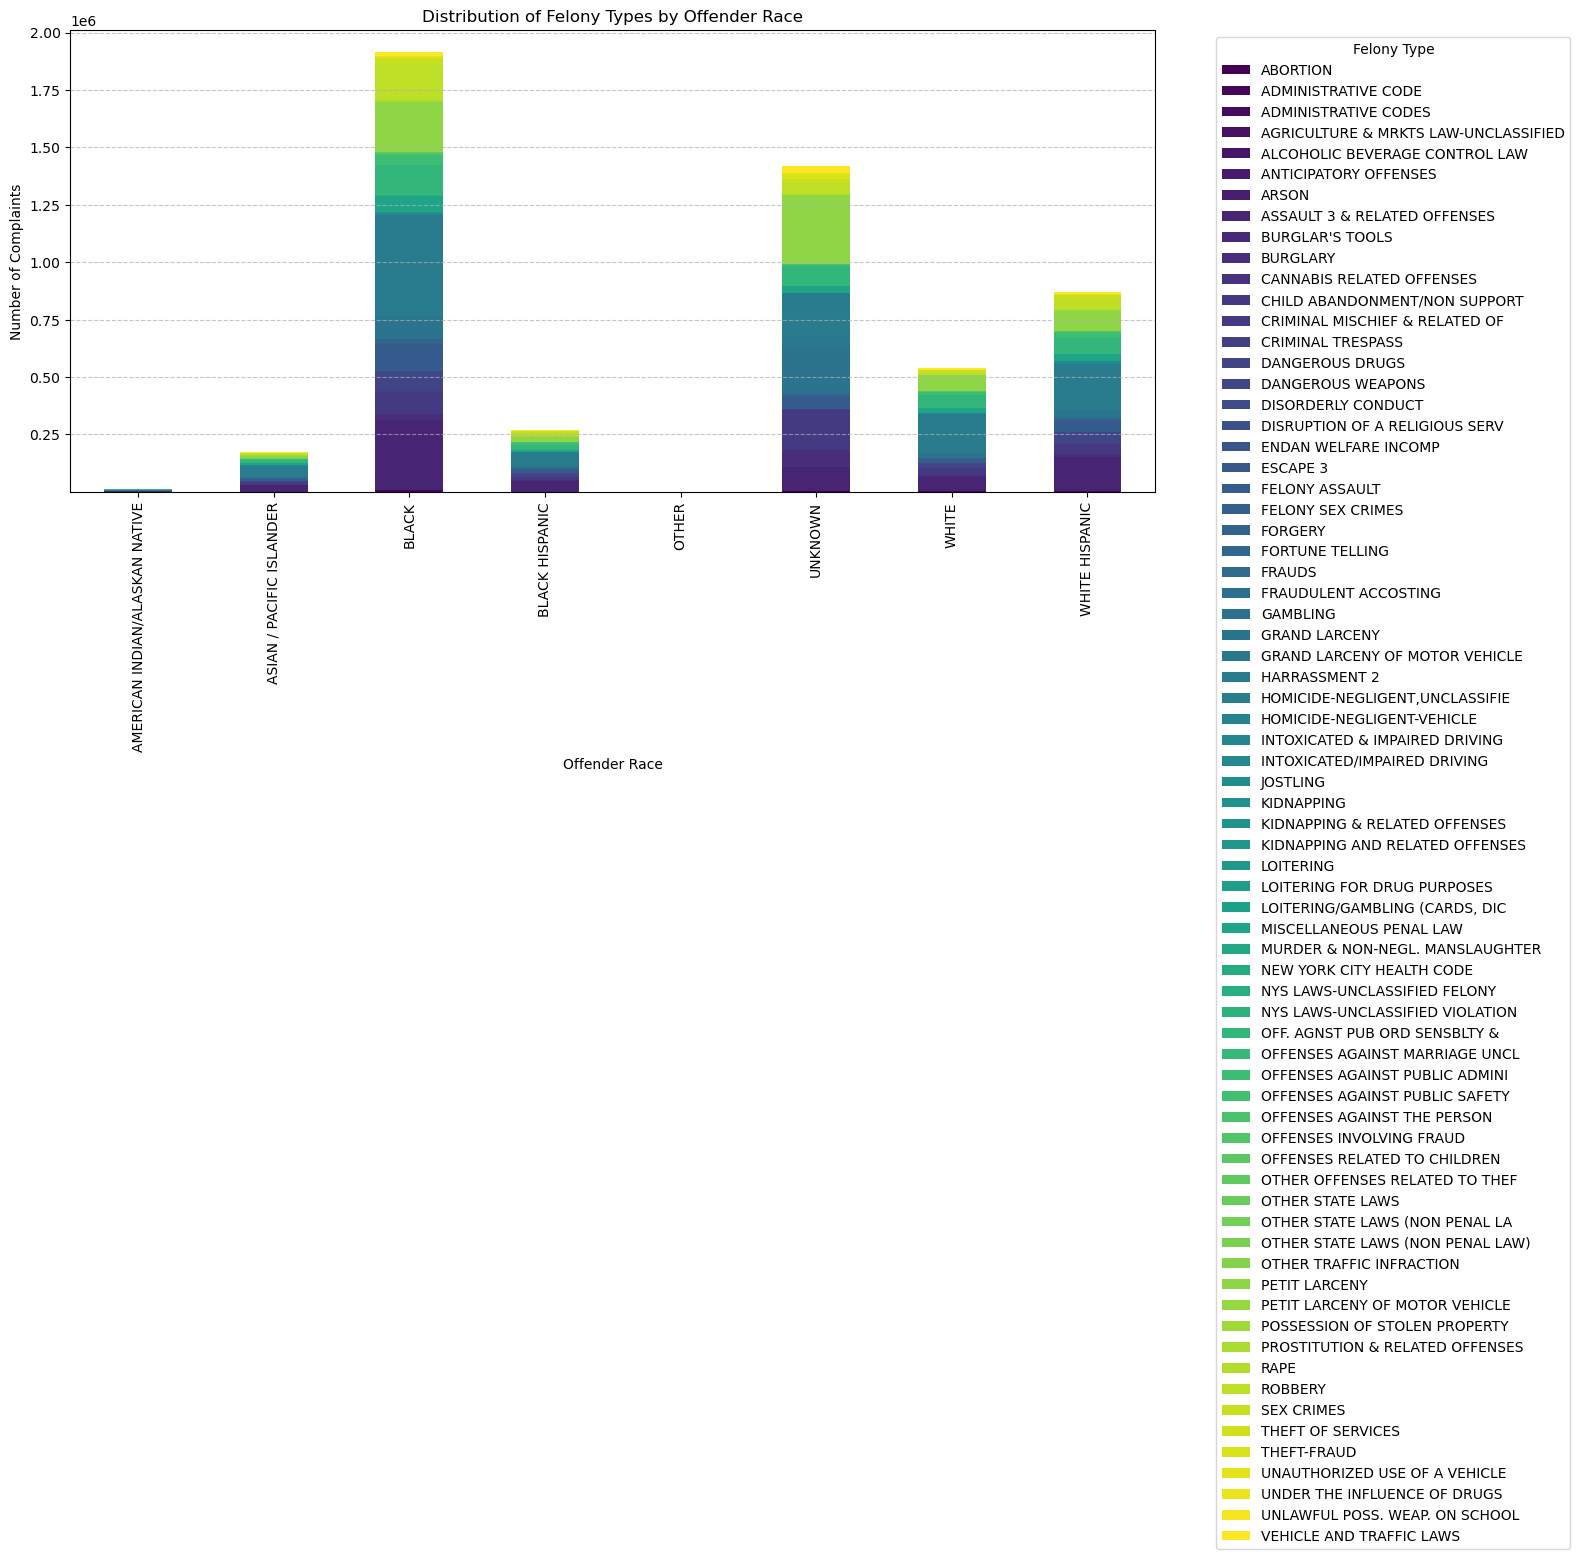

In [147]:
plt.figure(figsize=(14, 6))
crime_race_counts.T.plot(kind='bar', stacked=True, figsize=(14, 6), colormap='viridis')
plt.title('Distribution of Felony Types by Offender Race')
plt.xlabel('Offender Race')
plt.ylabel('Number of Complaints')
plt.legend(title='Felony Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


<Figure size 1400x600 with 0 Axes>

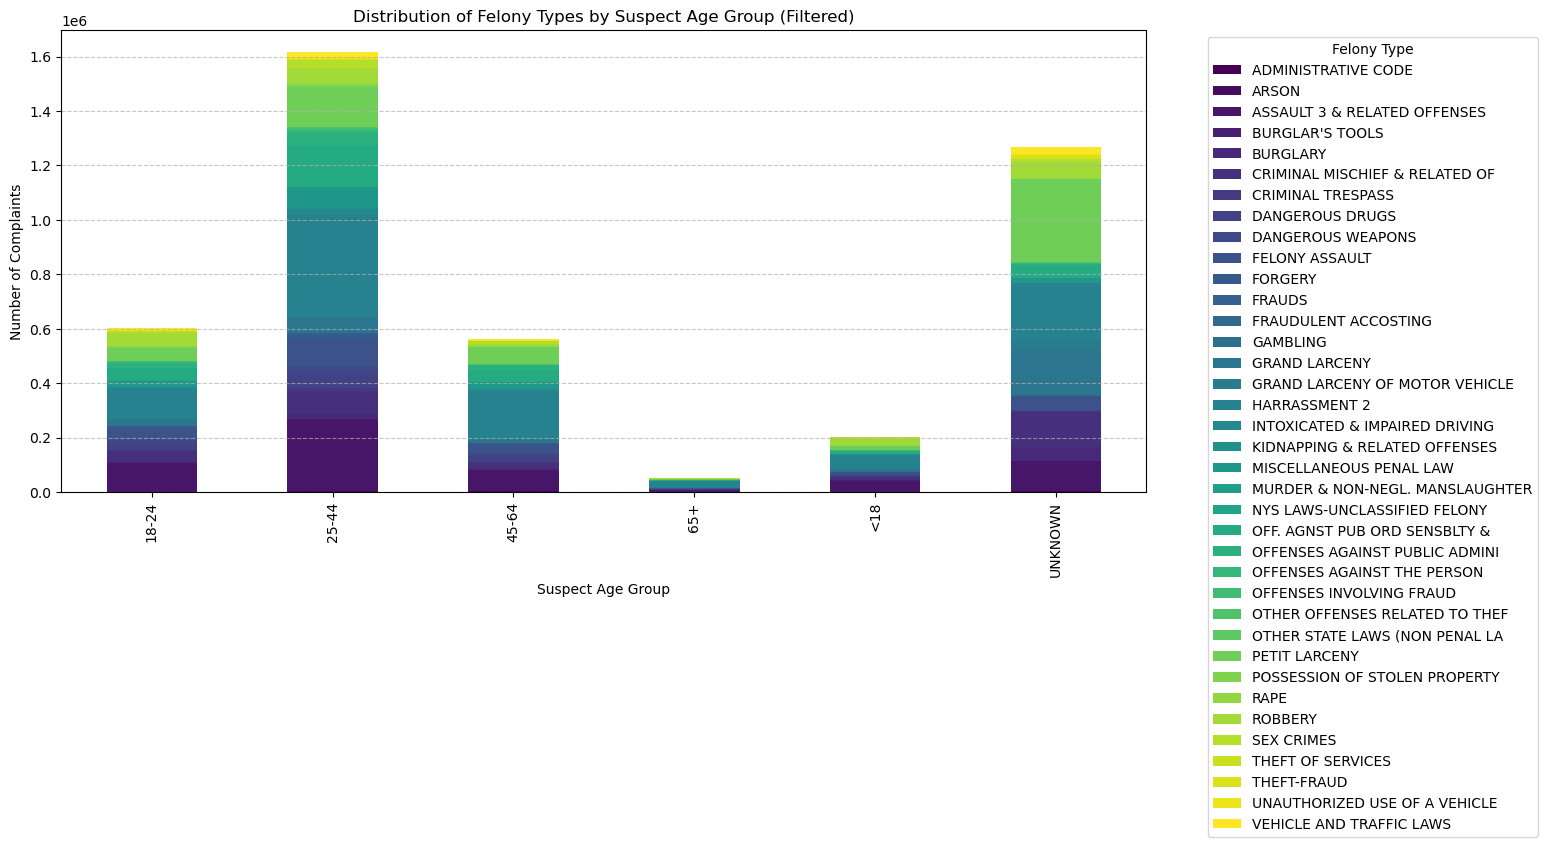

In [ ]:
crime_age_counts = df.groupby(['OFNS_DESC', 'SUSP_AGE_GROUP']).size().unstack()

filtered_age_counts = crime_age_counts.loc[:, crime_age_counts.sum(axis=0) >= 30]
filtered_age_counts = filtered_age_counts[filtered_age_counts.sum(axis=1) > 1000]

plt.figure(figsize=(14, 6))
filtered_age_counts.T.plot(kind='bar', stacked=True, figsize=(14, 6), colormap='viridis')
plt.title('Distribution of Felony Types by Suspect Age Group (Filtered)')
plt.xlabel('Suspect Age Group')
plt.ylabel('Number of Complaints')
plt.legend(title='Felony Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


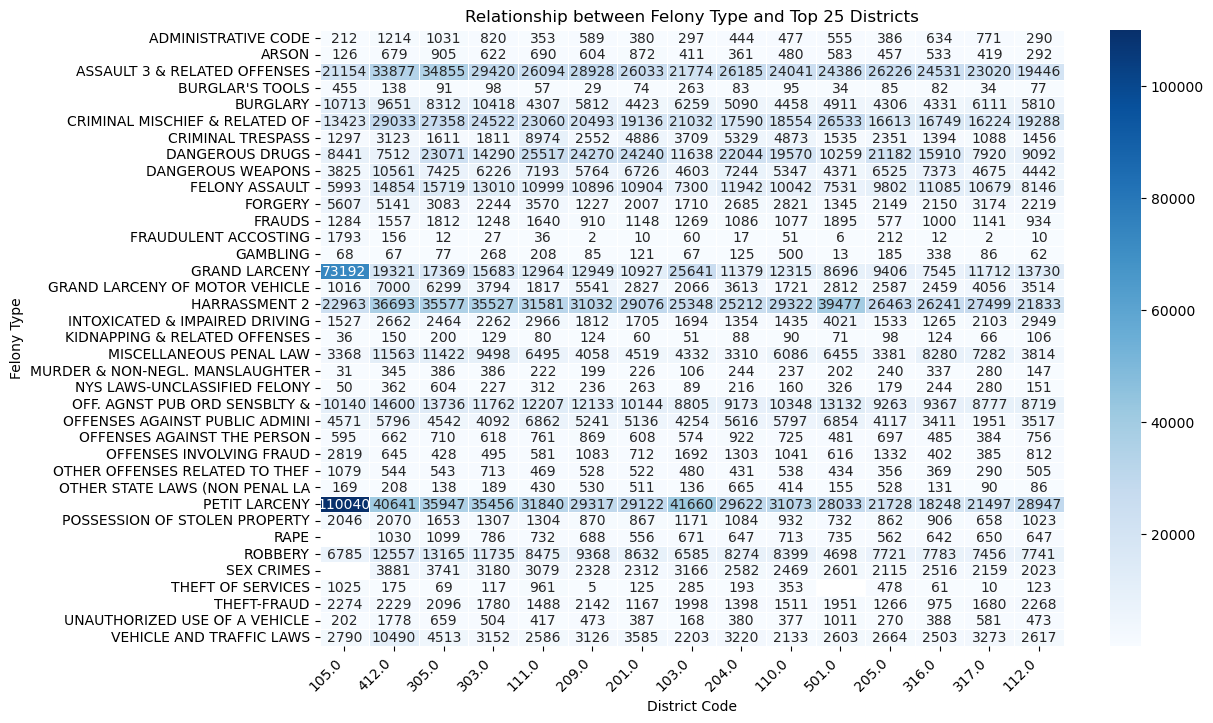

In [ ]:
# Count occurrences of each felony type per district
crime_district_counts = df.groupby(['OFNS_DESC', 'District_Code']).size().unstack()

# Keep only the top 25 districts with the most total crime occurrences
top_15_districts = crime_district_counts.sum(axis=0).nlargest(15).index
filtered_district_counts = crime_district_counts[top_15_districts]

# Filter out felony types with 100 occurrences or less
filtered_district_counts = filtered_district_counts[filtered_district_counts.sum(axis=1) > 1000]

plt.figure(figsize=(12, 8))
sns.heatmap(filtered_district_counts, cmap='Blues', annot=True, fmt='g', linewidths=0.5)
plt.title('Relationship between Felony Type and Top 25 Districts')
plt.xlabel('District Code')
plt.ylabel('Felony Type')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()
